In [1]:
# check the environment 

%ls

data/  sample_data/


# Imports 

In [0]:
# to install pytorch on colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install -U bcolz

In [0]:
!pip install Pillow==4.0.0

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import bcolz
import time

# GPU Settings 

In [8]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

dtype = torch.FloatTensor
if use_gpu:
    dtype = torch.cuda.FloatTensor

Using gpu: False 


# Data Loader

cf. https://mlelarge.github.io/dataflowr/

In [0]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # statistics from imagenet ? 

prep1 = transforms.Compose([
                transforms.CenterCrop(224), # default cropping 
                transforms.ToTensor(),
                normalize,
            ])

In [0]:
data_dir = '/content/data/sample'
#data_dir = '/content/data'

batch_size = 4
#batch_size = 64

In [0]:
# dictionary of datasets - in this case only train data set 
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

In [14]:
dset_classes = dsets['train'].classes
dset_classes # binary classes to begin 

['road', 'water']

In [0]:
# dictionary of data loaders - again only train for now 
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=0)
                for x in ['train', 'test']}

# Resnet

In [17]:
model_resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 80365628.49it/s]


In [0]:
for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(512, 2, bias = True)

# Training Framework

In [0]:
def train_model(model,data_loader,loss_fn,optimizer,n_epochs=1):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()    
                
            bs = labels.size(0)
            
            # define the loss to minimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            # define the optimizer
            optimizer = optimizer
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            optimizer.step()
            
            # predictions to get statistics 
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels.data)
            size += bs
        # epoch statistics     
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
    return loss_train, acc_train

# Running training epochs

# Using resnet 

In [20]:
conv_class = model_resnet
use_gpu = torch.cuda.is_available()
if use_gpu:
    conv_class = conv_class.cuda()


# choose the appropriate loss
loss_fn = torch.nn.CrossEntropyLoss()
# learning rate 
learning_rate = 1e-3
# your optimizer
optimizer_resnet = torch.optim.Adam(model_resnet.fc.parameters(), lr = learning_rate)
#optimizer_resnet = torch.optim.SGD(model_resnet.fc.parameters(), lr = learning_rate)


# and train for 5 epochs
l_t, a_t = train_model(conv_class, dset_loaders['train'], loss_fn, optimizer_resnet, n_epochs = 5)

Train - Loss: 0.1728 Acc: 0.5875
Train - Loss: 0.1694 Acc: 0.5750
Train - Loss: 0.1565 Acc: 0.6500
Train - Loss: 0.1513 Acc: 0.7000
Train - Loss: 0.1408 Acc: 0.7375


In [21]:
# and train for 10 epochs
l_t, a_t = train_model(conv_class, dset_loaders['train'], loss_fn, optimizer_resnet, n_epochs = 10)

Train - Loss: 0.1477 Acc: 0.6000
Train - Loss: 0.1277 Acc: 0.8125
Train - Loss: 0.1330 Acc: 0.8000
Train - Loss: 0.1416 Acc: 0.7000
Train - Loss: 0.1207 Acc: 0.7500
Train - Loss: 0.1115 Acc: 0.8875
Train - Loss: 0.1444 Acc: 0.7000
Train - Loss: 0.1300 Acc: 0.7625
Train - Loss: 0.1071 Acc: 0.8500
Train - Loss: 0.0969 Acc: 0.8875


# Test 

In [0]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
            
        bs = labels.size(0)
                
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        _,preds = torch.max(outputs.data,1)
        
        # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == labels.data)
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [23]:
test(conv_class, dset_loaders['test'])

Test - Loss: 0.1430 Acc: 0.7500


# Activation map

In [0]:
# model_resnet.eval()

In [0]:
import io
import requests
from PIL import Image
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow

In [0]:
finalconv_name = 'layer4'

In [0]:
features_blobs = []
def hook_feature(module, input, output):
    print('Inside ' + module.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    features_blobs.append(output.data.cpu().numpy())

conv_class._modules.get(finalconv_name).register_forward_hook(hook_feature);

In [27]:
conv_class._modules.get(finalconv_name)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [0]:
# get the softmax weight
params = list(conv_class.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [0]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        print(cam.shape)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
    
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [0]:
path = "/content/data/sample/train/water/train_18116.jpg"

#train_18116.jpg - water 
#train_7385.jpg - road 


from PIL import Image
img_pil = Image.open(path)
img_pil = img_pil.convert('RGB')
img_tensor = preprocess(img_pil)
#print(img_tensor.shape)


In [0]:
img_variable = img_tensor.unsqueeze(0)
img_variable.shape
logit = conv_class(img_variable)

In [0]:
classes = dict()
classes[0] = dset_classes[0]
classes[1] = dset_classes[1]

In [0]:
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [523]:
# output the prediction
for i in range(0, 1):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.568 -> water


In [524]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread(path)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

1
512
7
7
(49,)
output CAM.jpg for the top1 prediction: water


True

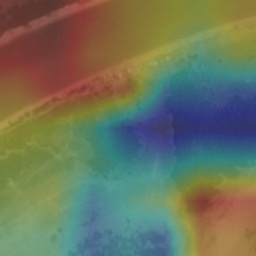

In [525]:
from IPython.display import Image
Image("CAM.jpg")

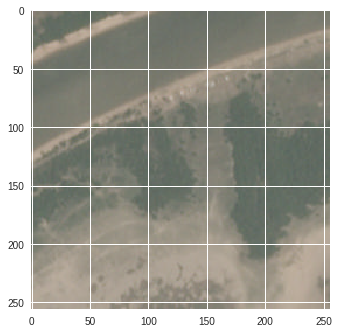

In [526]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()